/tmp/ipython-input-529166869.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Greens", N_MARKET_MAKERS+2)


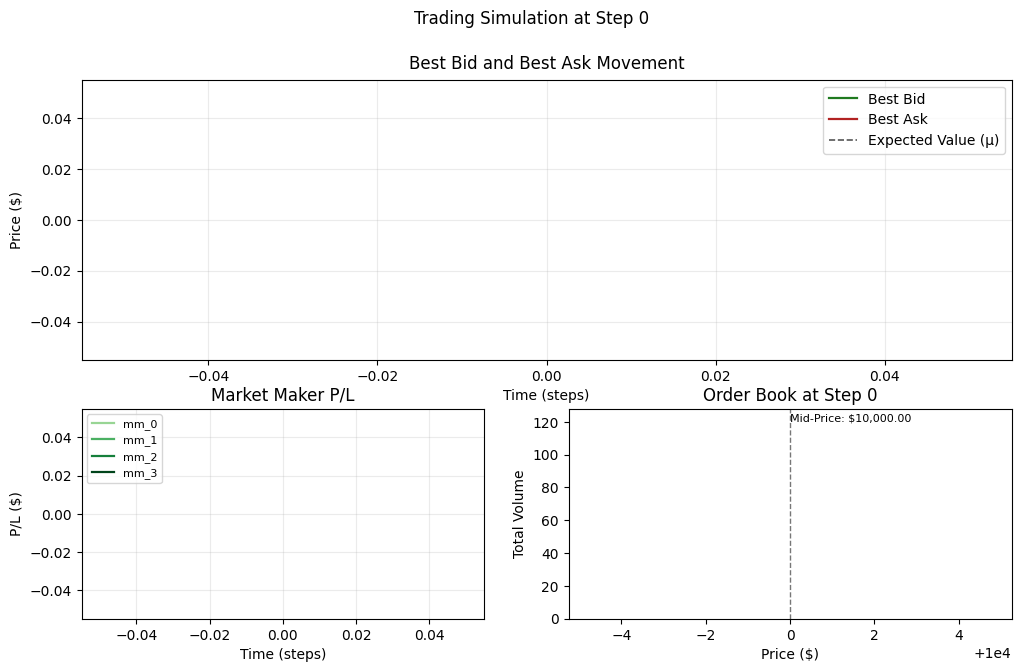

In [1]:
# Retry: generate and display the animated GIF again.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from IPython.display import Image, display

SEED            = 7
N_STEPS         = 160
DT              = 1/60
MID0            = 10_000.0
SIGMA           = 2.0
DRIFT           = 0.02
SPREAD_BASE     = 1.2
SPREAD_NOISE    = 0.6
N_LEVELS        = 8
TICK            = 0.5
DEPTH_SCALE     = 80.0
DEPTH_DECAY     = 0.65
N_MARKET_MAKERS = 4
INV_MR          = 0.90
INV_NOISE       = 3.0
SPREAD_CAPTURE  = 0.02
RNG             = np.random.default_rng(SEED)

COL_BID = "#1f7a1f"
COL_ASK = "#b22222"
COL_MU  = "#555555"

mid = np.empty(N_STEPS)
mu  = np.empty(N_STEPS)
spread = np.empty(N_STEPS)
mid[0] = MID0
mu[0]  = MID0
spread[0] = SPREAD_BASE + abs(RNG.normal(0, SPREAD_NOISE))
for t in range(1, N_STEPS):
    dW = RNG.normal(0, SIGMA)
    mid[t] = mid[t-1] + DRIFT*DT + dW
    mu[t]  = 0.98*mu[t-1] + 0.02*mid[t]
    spread[t] = max(0.01, SPREAD_BASE + RNG.normal(0, SPREAD_NOISE))
best_bid = mid - 0.5*spread
best_ask = mid + 0.5*spread

inv  = np.zeros((N_STEPS, N_MARKET_MAKERS))
pnl  = np.zeros((N_STEPS, N_MARKET_MAKERS))
for t in range(1, N_STEPS):
    inv[t] = INV_MR*inv[t-1] + RNG.normal(0, INV_NOISE, size=N_MARKET_MAKERS)
    dP = mid[t] - mid[t-1]
    dInv = inv[t] - inv[t-1]
    pnl[t] = pnl[t-1] + inv[t-1]*dP + SPREAD_CAPTURE*np.abs(dInv)*spread[t]

level_offsets = np.arange(1, N_LEVELS+1)
level_weights = (DEPTH_DECAY ** (level_offsets-1))
def gen_book_sizes():
    base = DEPTH_SCALE * level_weights
    noise = RNG.gamma(shape=2.0, scale=2.0, size=N_LEVELS)
    return np.maximum(0, base + noise - 2.5)
def price_levels_for_step(t):
    m = mid[t]
    bid_prices = m - level_offsets*TICK
    ask_prices = m + level_offsets*TICK
    return bid_prices, ask_prices

plt.close("all")
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(nrows=2, ncols=2, height_ratios=[2.0, 1.5], width_ratios=[1.0, 1.1], figure=fig)
ax_top  = fig.add_subplot(gs[0, :])
ax_pnl  = fig.add_subplot(gs[1, 0])
ax_book = fig.add_subplot(gs[1, 1])

line_bid, = ax_top.plot([], [], lw=1.6, color=COL_BID, label="Best Bid")
line_ask, = ax_top.plot([], [], lw=1.6, color=COL_ASK, label="Best Ask")
line_mu,  = ax_top.plot([], [], lw=1.2, color=COL_MU,  ls="--", label="Expected Value (μ)")
ax_top.set_title("Best Bid and Best Ask Movement", pad=8)
ax_top.set_xlabel("Time (steps)")
ax_top.set_ylabel("Price ($)")
ax_top.legend(loc="upper right")
ax_top.grid(True, alpha=0.25)

mm_lines = []
cmap = cm.get_cmap("Greens", N_MARKET_MAKERS+2)
for i in range(N_MARKET_MAKERS):
    (ln,) = ax_pnl.plot([], [], lw=1.6, label=f"mm_{i}", color=cmap(i+2))
    mm_lines.append(ln)
ax_pnl.set_title("Market Maker P/L", pad=6)
ax_pnl.set_xlabel("Time (steps)")
ax_pnl.set_ylabel("P/L ($)")
ax_pnl.legend(loc="upper left", ncols=1, fontsize=8)
ax_pnl.grid(True, alpha=0.25)

ax_book.set_title("Order Book at Step 0", pad=6)
ax_book.set_xlabel("Price ($)")
ax_book.set_ylabel("Total Volume")
bar_width = TICK * 0.85
bid_bar_levels = []
ask_bar_levels = []

bid_x0, ask_x0 = price_levels_for_step(0)
bid_bottom0 = np.zeros_like(bid_x0, dtype=float)
ask_bottom0 = np.zeros_like(ask_x0, dtype=float)
bid_colors = [cm.Greens(0.35 + 0.5 * (i/(N_LEVELS-1))) for i in range(N_LEVELS)]
ask_colors = [cm.Reds(0.35 + 0.5 * (i/(N_LEVELS-1)))   for i in range(N_LEVELS)]

for i in range(N_LEVELS):
    bars_bid = ax_book.bar(bid_x0, np.zeros_like(bid_x0), bar_width,
                           bottom=bid_bottom0, color=bid_colors[i], edgecolor="none", alpha=0.9)
    bars_ask = ax_book.bar(ask_x0, np.zeros_like(ask_x0), bar_width,
                           bottom=ask_bottom0, color=ask_colors[i], edgecolor="none", alpha=0.9)
    bid_bar_levels.append(bars_bid)
    ask_bar_levels.append(bars_ask)

mid_line = ax_book.axvline(MID0, ls="--", color="#777777", lw=1.0)
mid_txt  = ax_book.text(MID0, 0.98, f"Mid-Price: ${MID0:,.2f}",
                        ha="left", va="top", transform=ax_book.get_xaxis_transform(), fontsize=8)

book_span = (N_LEVELS+1) * TICK
ax_book.set_xlim(MID0 - book_span - 1.5*TICK, MID0 + book_span + 1.5*TICK)
ax_book.set_ylim(0, DEPTH_SCALE*1.6)
fig.suptitle("Trading Simulation at Step 0", y=0.98, fontsize=12)
xdata = np.arange(N_STEPS)

def update(frame):
    line_bid.set_data(xdata[:frame+1], best_bid[:frame+1])
    line_ask.set_data(xdata[:frame+1], best_ask[:frame+1])
    line_mu.set_data(xdata[:frame+1],  mu[:frame+1])

    ax_top.set_xlim(0, max(50, frame))
    mseg = mid[max(0, frame-80):frame+1]
    ax_top.set_ylim(np.min(mseg)-2.5, np.max(mseg)+2.5)

    for i, ln in enumerate(mm_lines):
        ln.set_data(xdata[:frame+1], pnl[:frame+1, i])
    seg = pnl[max(0, frame-80):frame+1, :]
    ymin = np.min(seg) - 2.0
    ymax = np.max(seg) + 2.0
    if np.isfinite(ymin) and np.isfinite(ymax) and ymax > ymin:
        ax_pnl.set_xlim(0, max(50, frame))
        ax_pnl.set_ylim(ymin, ymax)

    ax_book.set_title(f"Order Book at Step {frame}")
    bp, ap = price_levels_for_step(frame)
    bid_sizes = gen_book_sizes()
    ask_sizes = gen_book_sizes()
    m = mid[frame]
    ax_book.set_xlim(m - book_span - 1.5*TICK, m + book_span + 1.5*TICK)

    mid_line.set_xdata([m, m])
    mid_txt.set_text(f"Mid-Price: ${m:,.2f}")
    mid_txt.set_x(m)

    cum_bid = np.zeros_like(bid_sizes)
    cum_ask = np.zeros_like(ask_sizes)

    for lvl in range(N_LEVELS):
        for rect, x in zip(bid_bar_levels[lvl], bp):
            rect.set_x(x - bar_width/2)
        for rect, x in zip(ask_bar_levels[lvl], ap):
            rect.set_x(x - bar_width/2)

        bid_h = np.maximum(0, bid_sizes * (DEPTH_DECAY ** (lvl*0.35)) + np.random.normal(0, 1.5, size=N_LEVELS))
        ask_h = np.maximum(0, ask_sizes * (DEPTH_DECAY ** (lvl*0.35)) + np.random.normal(0, 1.5, size=N_LEVELS))

        for j, rect in enumerate(bid_bar_levels[lvl]):
            rect.set_height(bid_h[j])
            rect.set_y(cum_bid[j])
        cum_bid += bid_h

        for j, rect in enumerate(ask_bar_levels[lvl]):
            rect.set_height(ask_h[j])
            rect.set_y(cum_ask[j])
        cum_ask += ask_h

    ymax_book = max(np.max(cum_bid), np.max(cum_ask))
    ax_book.set_ylim(0, max(10.0, ymax_book * 1.15))
    fig.suptitle(f"Trading Simulation at Step {frame}", y=0.98, fontsize=12)
    return ()

#anim = FuncAnimation(fig, update, frames=N_STEPS, interval=30, blit=False)
#outfile = "/mnt/data/trading_sim.gif"


In [2]:
# Save + show inline in notebooks
#outfile = "trading_sim.gif"
#anim.save(outfile, writer=PillowWriter(fps=24))
#plt.close(fig)  # hide the static first frame Jupyter would show

#from IPython.display import Image, display
#display(Image(filename=outfile))   # <-- shows the animated GIF
